In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.sampledata.unemployment1948 import data

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# border and row shading fro tables
a_color = "saddlebrown"
table_row = "saddlebrown"

## !! Begin Note book variables !!
# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/survey_areas/aare_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'aare', 'name':"Erhebungsgebiet Aare", 'level':'river_bassin'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'water_name_slug'

# identify the lakes of interest for the survey area
lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]

# !! End note book variables !!

## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# !key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
# !this is the feature data!
fd = fdx.feature_data

# !keyword args to build period data
# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data. For a survey area
# or river bassin these_features = feature_paren and 
# feature_level = parent_level
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
# this can be done by updating the fd_kwargs
fd_rivers = fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()

# update the admin kwargs with river data to make the river summary
admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

Codes init called
this is german
making material and description map
making feature data
There are columns
renaming columns
sample totals
making daily total summary
making the code summary first
making material summary
getting the fail rate
making most common codes table
Codes init called
making feature data
There are columns
renaming columns


In [2]:
rivers = admin_details.riversOfInterest()
lakes = admin_details.lakesOfInterest()
        
# string objects for display
obj_string = featuredata.thousandsSeparator(admin_summary["quantity"], language)
surv_string = "{:,}".format(admin_summary["loc_date"])
pop_string = featuredata.thousandsSeparator(int(admin_summary["population"]), language)

# make strings
date_quantity_context = F"Im Zeitraum von {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)}  bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= date_lang)} wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {this_feature['name']} umfassen {admin_summary['location']} Orte, {admin_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnenden."

# lists of landmarks of interest
munis_joined = ", ".join(sorted(admin_details.populationKeys()["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Seen:*\n\n>{lakes_joined}

*Fliessgewässer:*\n\n>{rivers_joined}

*Gemeinden:*\n\n>{munis_joined}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 140 Datenerhebungen insgesamt 13 847 Objekte entfernt und identifiziert. Die Ergebnisse des Erhebungsgebiet Aare umfassen 51 Orte, 35 Gemeinden und eine Gesamtbevölkerung von etwa 493 799 Einwohnenden.

*Seen:*

>Bielersee, Brienzersee, Neuenburgersee, Thunersee

*Fliessgewässer:*

>Aare, Aare|Nidau-Büren-Kanal, Emme, La Thièle, Schüss

*Gemeinden:*

>Aarau, Beatenberg, Bern, Biel/Bienne, Boudry, Brienz (BE), Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Erlach, Estavayer, Gals, Gebenstorf, Grandson, Hauterive (NE), Kallnach, Köniz, Le Landeron, Ligerz, Luterbach, Lüscherz, Neuchâtel, Nidau, Port, Rubigen, Solothurn, Spiez, Thun, Unterseen, Vinelz, Walperswil, Yverdon-les-Bains


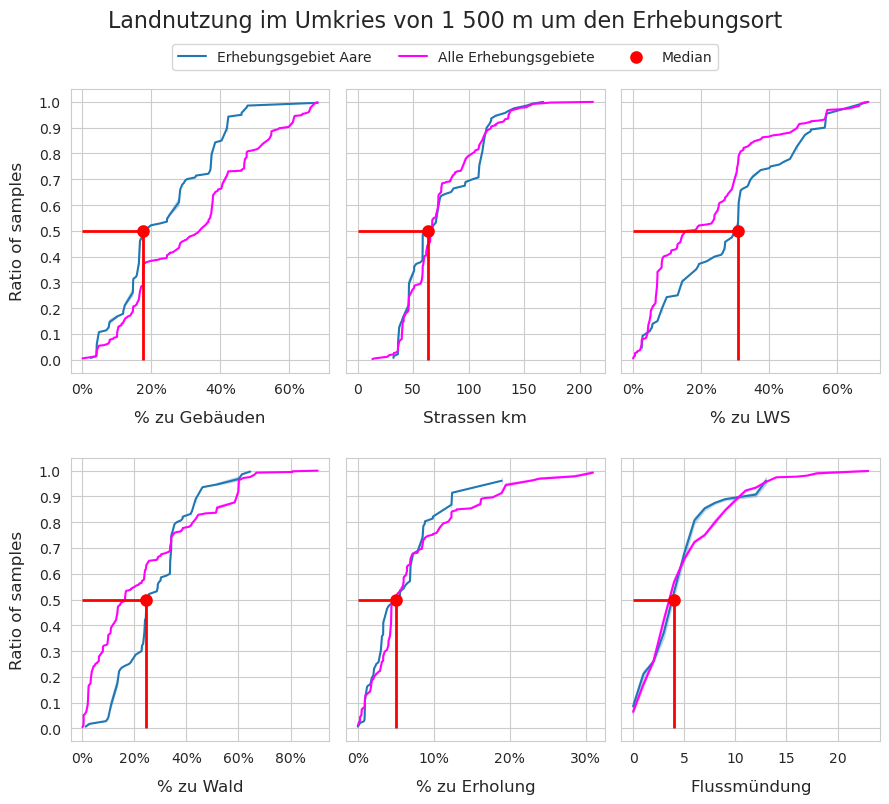

In [3]:
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
   
}
project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()

land_use_kwargs.update({"data":fdx.feature_data})
feature_profile = featuredata.LandUseProfile(**land_use_kwargs).featureOfInterest()

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")
from matplotlib.ticker import MultipleLocator
for i, n in enumerate(featuredata.default_land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]
    
    # the value of landuse feature n for the survey area:
    data=feature_profile[n].values
    xs, ys = featuredata.empiricalCDF(data)   
    sns.lineplot(x=xs, y=ys, ax=ax, label=admin_details.label)
    
    # the value of the land use feature n for all the data
    testx, testy = featuredata.empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label=top, color="magenta")
    
    # get the median from the data
    the_median = np.median(data)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    if i <= 3:
        if c == 0:            
            ax.set_ylabel("Ratio of samples", **ck.xlab_k)
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_xlabel(list(featuredata.luse_ge.values())[i], **ck.xlab_k)
    
plt.tight_layout()
plt.subplots_adjust(top=.9, hspace=.3)
plt.suptitle("Landnutzung im Umkries von 1 500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.94), loc="center", ncol=3) 

# glue("aare_survey_area_landuse", fig, display=False)

plt.show()

In [4]:


dims_data = admin_details.dimensionalSummary()

dims_data

,total_w,mac_plast_w,area,length,samples,quantity
feature,,,,,,
Aare,13.782,5864.50,2817.0,672.0,15.0,478.0
Aare|Nidau-Büren-Kanal,2.145,260.00,976.0,146.0,3.0,155.0
Bielersee,13.105,6668.00,6343.0,1247.0,38.0,4477.0
Brienzersee,2.270,1972.12,1143.0,230.0,5.0,974.0
Emme,2.910,1130.00,405.0,45.0,1.0,41.0
La Thièle,0.001,1.00,13.0,19.0,1.0,9.0
Neuenburgersee,17.427,9451.00,15426.0,3354.0,44.0,4825.0
Schüss,0.360,210.00,381.0,92.0,2.0,98.0
Thunersee,19.976,5891.55,9513.8,2166.0,31.0,2790.0


In [5]:
fdx.material_summary

,material,quantity,% of total
6,Plastik,11622,0.839315
1,Glas,874,0.063118
4,Metall,579,0.041814
5,Papier,391,0.028237
0,Chemikalien,99,0.007150
2,Gummi,96,0.006933
3,Holz,94,0.006788
7,Stoff,92,0.006644
8,Unbekannt,0,0.000000


In [6]:
fdx.sample_summary

Erhebungen               140.00
Durchschnitt p/100 m     225.43
Standardabweichung       234.00
min p/100 m                2.00
25%                       63.50
50%                      143.50
75%                      315.50
max p/100 m             1480.00
dtype: float64

In [7]:
fdx.most_common

,p/100 m,quantity,% of total,fail,fail rate,item,material
code,,,,,,,
G27,11.0,2561,18.49,118,84,Zigarettenfilter,Plastik
Gfrags,18.5,2004,14.47,125,89,Fragmentierte Kunststoffe,Plastik
G30,8.0,900,6.50,115,82,Snack-Verpackungen,Plastik
Gfoam,4.0,839,6.06,91,65,Expandiertes Polystyrol,Plastik
G67,5.0,812,5.86,103,73,Industriefolie (Kunststoff),Plastik
G200,3.0,687,4.96,95,67,"Getränke Glasflasche, Stücke",Glas
G941,0.5,445,3.21,70,50,"Verpackungsfolien, nicht für Lebensmittel",Plastik
G74,0.0,298,2.15,68,48,Schaumstoffverpackungen/Isolierung,Plastik
G117,0.0,292,2.11,39,27,Styropor < 5mm,Plastik


In [8]:
output_notebook()

Loading BokehJS ...

In [9]:
dx = period_data.parentSampleTotals(parent=False)
d = fdx.sample_totals


p = figure(x_axis_type="datetime")

p.circle(dx["date"], dx["p/100 m"], fill_color="black", size=10, line_width=0)
p.circle(d["date"], d["p/100 m"], fill_color="magenta", size=10, line_width=0)
show(p)

making sample totals from period data
make no mask


In [10]:
# map to proper names for features
feature_names = admin_details.makeFeautureNameMap()

components = fdx.componentMostCommonPcsM()

# pivot that
mc_comp = components[["item", unit_label, "water_name_slug"]].pivot(columns="water_name_slug", index="item")

# quash the hierarchal column index
mc_comp.columns = mc_comp.columns.get_level_values(1)

proper_column_names = {x : feature_names.loc[x, 'water_name'] for x in mc_comp.columns}
mc_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the survey area
mc_feature = fdx.most_common[unit_label]
mc_feature = featuredata.changeSeriesIndexLabels(mc_feature, {x:fdx.dMap.loc[x] for x in mc_feature.index})

# the aggregated totals of all the data
mc_period = period_data.parentMostCommon(parent=False)
mc_period = featuredata.changeSeriesIndexLabels(mc_period, {x:fdx.dMap.loc[x] for x in mc_period.index})

mc_comp[this_feature["name"]]= mc_feature
mc_comp[top] = mc_period

mc_comp

getting the most common results from period data
make no mask
getting most common pcs/m from period data


water_name_slug,Aare,Aare|Nidau-Büren-Kanal,Bielersee,Brienzersee,Emme,La Thièle,Neuenburgersee,Schüss,Thunersee,Erhebungsgebiet Aare,Alle Erhebungsgebiete
item,,,,,,,,,,,
Expandiertes Polystyrol,0.0,0.0,5.5,15.0,0.0,10.0,3.0,0.0,10.0,4.0,5.0
Fragmentierte Kunststoffe,0.0,4.0,53.0,53.0,2.0,0.0,15.0,6.0,12.0,18.5,18.0
"Getränke Glasflasche, Stücke",0.0,3.0,5.5,0.0,0.0,0.0,5.0,15.0,3.0,3.0,3.0
Industriefolie (Kunststoff),0.0,0.0,18.0,47.0,22.0,5.0,2.0,0.0,5.0,5.0,5.0
Industriepellets (Nurdles),0.0,0.0,2.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Schaumstoffverpackungen/Isolierung,0.0,0.0,1.0,5.0,0.0,0.0,0.5,0.0,2.0,0.0,1.0
Snack-Verpackungen,2.0,1.0,21.0,27.0,2.0,5.0,7.0,8.5,4.0,8.0,9.0
Styropor < 5mm,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
Verpackungen aus Aluminiumfolie,0.0,0.0,2.5,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0


In [11]:
components = fdx.componentCodeGroupResults()

# pivot that
pt_comp = components[["water_name_slug", "groupname", '% of total' ]].pivot(columns="water_name_slug", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the parent level
pt_parent = period_data.parentGroupTotals(parent=True, percent=True)
pt_comp[this_feature["name"]] = pt_parent

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=True)
pt_comp[top] = pt_period
pt_comp

getting the codegroup results from period data
mask is for parent level
applying mask
getting the codegroup % of total from period data
getting the codegroup results from period data
make no mask
getting the codegroup % of total from period data


water_name_slug,Aare,Aare|Nidau-Büren-Kanal,Bielersee,Brienzersee,Emme,La Thièle,Neuenburgersee,Schüss,Thunersee,Erhebungsgebiet Aare,Alle Erhebungsgebiete
groupname,,,,,,,,,,,
Abwasser,33.0,1.0,3.0,2.0,0.0,0.0,5.0,1.0,2.0,4.0,5.0
Essen und Trinken,14.0,26.0,19.0,14.0,15.0,22.0,22.0,37.0,17.0,19.0,19.0
Freizeit und Erholung,2.0,3.0,8.0,4.0,2.0,0.0,4.0,12.0,4.0,5.0,4.0
Infrastruktur,13.0,8.0,11.0,13.0,7.0,22.0,13.0,6.0,18.0,13.0,18.0
Landwirtschaft,6.0,1.0,8.0,16.0,44.0,11.0,3.0,4.0,10.0,7.0,6.0
Mikroplastik (< 5mm),6.0,1.0,5.0,14.0,0.0,33.0,5.0,0.0,2.0,5.0,8.0
Persönliche Gegenstände,4.0,1.0,3.0,2.0,7.0,0.0,4.0,3.0,2.0,3.0,3.0
Plastikfragmente,9.0,13.0,17.0,16.0,2.0,0.0,14.0,6.0,13.0,14.0,14.0
Tabakwaren,10.0,42.0,19.0,11.0,7.0,11.0,21.0,26.0,24.0,20.0,17.0


In [12]:
fd_rivers = fd_kwargs.update({"water_type":"r"})

fdr = featuredata.Components(**fd_kwargs)
fdr.adjustForLanguage()
fdr.makeFeatureData()
fdr.locationSampleTotals()
fdr.makeDailyTotalSummary()
fdr.materialSummary()
fdr.mostCommon()

Codes init called
this is german
making material and description map
making feature data
There are columns
renaming columns
sample totals
making daily total summary
making the code summary first
making material summary
getting the fail rate
making most common codes table


In [13]:
dr = fdr.sample_totals
p = figure(x_axis_type="datetime")

p.circle(d["date"], d["p/100 m"], fill_color="black", size=10, line_width=0)
p.circle(dr["date"], dr["p/100 m"], fill_color="magenta", size=10, line_width=0)
show(p)

In [14]:
fdr.sample_summary

Erhebungen               22.00
Durchschnitt p/100 m    100.27
Standardabweichung      103.97
min p/100 m               2.00
25%                      24.25
50%                      60.00
75%                     106.50
max p/100 m             363.00
dtype: float64

In [15]:
fdr.most_common

,p/100 m,quantity,% of total,fail,fail rate,item,material
code,,,,,,,
G27,6.0,133,17.03,15,68,Zigarettenfilter,Plastik
G98,0.0,117,14.98,5,22,Windeln – Feuchttücher,Plastik
Gfrags,3.0,68,8.71,13,59,Fragmentierte Kunststoffe,Plastik
G30,2.5,41,5.25,15,68,Snack-Verpackungen,Plastik
Gfoam,0.0,37,4.74,5,22,Expandiertes Polystyrol,Plastik
G67,0.0,33,4.23,7,31,Industriefolie (Kunststoff),Plastik
G200,0.0,30,3.84,6,27,"Getränke Glasflasche, Stücke",Glas
G144,0.0,17,2.18,1,4,Tampons,Stoff
G117,0.0,17,2.18,2,9,Styropor < 5mm,Plastik


In [16]:
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)
agg_pcs_median = {unit_label:"median", "quantity":"sum"}
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())
mask = ((before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(admin_summary["locations_of_interest"])))

fd_frags_foams = before_agg[mask].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: fdx.dMap.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams

,p/100 m,quantity,item,% of total
code,,,,
G74,0.0,41,Schaumstoffverpackungen/Isolierung,0.30
G75,0.0,22,"Objekte aus Kunststoff/Polystyrol 0,5 - 2,5 cm",0.16
G76,0.0,9,"Kunststoff/Polystyrolschaumstoff 2,5 > < 50",0.06
G78,8.0,1051,"Objekte aus Kunststoff 0,5 - 2,5 cm",7.59
G79,7.0,921,"Objekte aus Kunststoff 2,5 - 50 cm",6.65
G80,0.0,1,Objekte aus Kunststoff > 50 cm,0.01
G81,1.0,567,"Objekte aus expandiertem Polystyrol 0,5 - 2,5 cm",4.09
G82,1.0,272,"Objekte aus expandiertem Polystyrol 2,5 - 50 cm",1.96
G83,0.0,0,Objekte aus expandiertem Polystyrol > 50 cm,0.00


In [17]:
from bokeh.plotting import figure, show
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge, factor_cmap

periods = ["I", "II", "III", "IV", "V", "VI", "VII"]
groups = [str(x) for x in range(1, 19)]

df = elements.copy()
df["atomic mass"] = df["atomic mass"].astype(str)
df["group"] = df["group"].astype(str)
df["period"] = [periods[x-1] for x in df.period]
df = df[df.group != "-"]
df = df[df.symbol != "Lr"]
df = df[df.symbol != "Lu"]

cmap = {
    "alkali metal"         : "#a6cee3",
    "alkaline earth metal" : "#1f78b4",
    "metal"                : "#d93b43",
    "halogen"              : "#999d9a",
    "metalloid"            : "#e08d49",
    "noble gas"            : "#eaeaea",
    "nonmetal"             : "#f1d4Af",
    "transition metal"     : "#599d7A",
}

TOOLTIPS = [
    ("Name", "@name"),
    ("Atomic number", "@{atomic number}"),
    ("Atomic mass", "@{atomic mass}"),
    ("Type", "@metal"),
    ("CPK color", "$color[hex, swatch]:CPK"),
    ("Electronic configuration", "@{electronic configuration}"),
]

p = figure(title="Periodic Table (omitting LA and AC Series)", width=1000, height=450,
           x_range=groups, y_range=list(reversed(periods)),
           tools="hover", toolbar_location=None, tooltips=TOOLTIPS)

r = p.rect("group", "period", 0.95, 0.95, source=df, fill_alpha=0.6, legend_field="metal",
           color=factor_cmap('metal', palette=list(cmap.values()), factors=list(cmap.keys())))

text_props = dict(source=df, text_align="left", text_baseline="middle")

x = dodge("group", -0.4, range=p.x_range)

p.text(x=x, y="period", text="symbol", text_font_style="bold", **text_props)

p.text(x=x, y=dodge("period", 0.3, range=p.y_range), text="atomic number",
       text_font_size="11px", **text_props)

p.text(x=x, y=dodge("period", -0.35, range=p.y_range), text="name",
       text_font_size="7px", **text_props)

p.text(x=x, y=dodge("period", -0.2, range=p.y_range), text="atomic mass",
       text_font_size="7px", **text_props)

p.text(x=["3", "3"], y=["VI", "VII"], text=["LA", "AC"], text_align="center", text_baseline="middle")

p.outline_line_color = None
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_standoff = 0
p.legend.orientation = "horizontal"
p.legend.location ="top_center"
p.hover.renderers = [r] # only hover element boxes

show(p)